<ipython-input-3-b7468a690088>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0081 - val_loss: 4.3750e-04
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 2.5717e-04 - val_loss: 3.1291e-04
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3288e-04 - val_loss: 2.5302e-04
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7269e-04 - val_loss: 2.6339e-04
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6896e-04 - val_loss: 4.5334e-04
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8933e-04 - val_loss: 2.0461e-04
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0346e-04 - val_loss: 0.0031
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8273e-04 - val_loss: 2.0460e-04
Epoch 9/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3864e-04 - val_loss: 3.1218e-04
Epoch 10/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.2604e-04 - val_loss: 1.7259e-04
Epoch 11/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

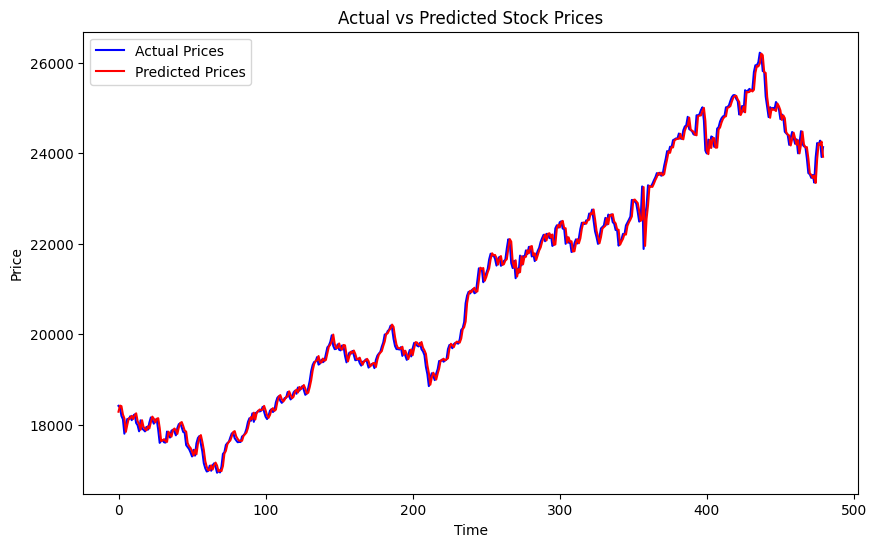

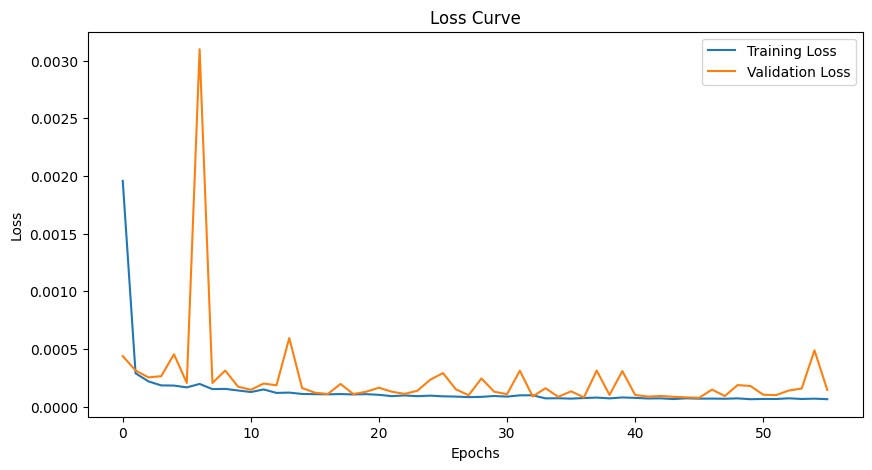

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# 1. Load the data
data_path = os.path.join("..", "data", "Nifty50_Train.csv")
data = pd.read_csv(data_path)
data = data[['Close']]

# 2. Handle missing data
data.fillna(method='ffill', inplace=True)

# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# 4. Prepare input sequences
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# 5. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 6. Build the model with improvements
units = 256  # Increased LSTM units for better learning
dropout_rate = 0.02  # Reduced dropout to retain more information
batch_size = 8  # Increased batch size for better updates
learning_rate = 0.0005  # Reduced learning rate for better convergence

model = Sequential([
    LSTM(units, return_sequences=False, input_shape=(sequence_length, X.shape[2])),
    Dropout(dropout_rate),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Add early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs for better training
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1  # Set to 1 to print epoch details
)

# Best model with validation loss
val_loss = min(history.history['val_loss'])
print(f"Best model with val_loss={val_loss:.4f}")

# 7. Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual prices
predicted_prices = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1)
)[:, 0]

actual_prices = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1)
)[:, 0]

# 8. Calculate MAE and RMSE
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 9. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Prices", color='red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# 10. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Create relative path to the models folder
model_path = os.path.join("..", "models", "LSTM_model_best.h5")

# Save the trained model
model.save(model_path)